In [1]:
from chase.base import *
from chase.utils import *
from chase.fit import *
from mypy.explib.frey2014 import frey2014
pd.set_option('display.max_colwidth', 100)
sns.set_style("whitegrid")

FIGDEST = '/Users/markant/Dropbox/sharelatex/ssDFE/ssDFEpsychrev_v0/figures/'

In [2]:
data = pd.read_csv('data/frey_data.csv', index_col=0)
problems = {gid: frey2014.get_options(gid) for gid in data.problem.unique()}
arr = []
for i, row in data.iterrows():
    arr.append(row['problem'].split('G')[0])
data['session'] = arr

In [3]:
# a list of possible free parameters and their ranges
# and starting point (optional)
PARS = {'theta': [1, 50],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'mu': [0., np.inf, 10.],
        'sc': [0., np.inf, 1.],
        'p_stop': [0, 1, .5]}

# parameters that are set to fixed values 
FIXED = {'c': 0.5,
         'theta': 30}
FIXED_OPT = {'c': 0.5}

OUTDIR = 'chase_fitresults_frey_session'

PARSETS_GEOM = [['p_stop', 'p_stay', 'tau'],
                ['p_stop', 'p_stay', 'tau', 'prelec_gamma'],
                ['p_stop', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                ['p_stop', 'p_stay', 'tau', 'pow_gain'],
                ['p_stop', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
               ]

PARSETS_NORMAL = [['mu', 'sc', 'p_stay', 'tau'],
                  ['mu', 'sc', 'p_stay', 'tau', 'prelec_gamma'],
                  ['mu', 'sc', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                  ['mu', 'sc', 'p_stay', 'tau', 'pow_gain'],
                  ['mu', 'sc', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
                  ]

PARSETS_OPT = [['theta', 'p_stay', 'tau'],
               ['theta', 'p_stay', 'tau', 'prelec_gamma'],
               ['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
               ['theta', 'p_stay', 'tau', 'pow_gain'],
               ['theta', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
              ]


COMPARISON_RESULTS = {}

def model_table(sid, force=False):
    if sid not in COMPARISON_RESULTS or force:
        COMPARISON_RESULTS[sid] = pd.read_csv(OUTDIR+'/modelcomparison_session=%s.csv' % sid, index_col=0)
    return COMPARISON_RESULTS[sid]

In [29]:
for sid in data.session.unique():

    results = pd.DataFrame([], columns=['sim_id', 'stoprule', 'weighting', 
                                        'k', 'N', 'nllh', 'bic', 'p_stay', 'tau', 
                                        'theta', 'p_stop', 'mu', 'sc', 
                                        'prelec_gamma', 'prelec_elevation',
                                        'pow_gain', 'w_loss'])

    for i, parset in enumerate(PARSETS_OPT):
        model_id = 'frey_individual_session=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        b = best_result(model_id, FIXED_OPT, fitting, outdir=OUTDIR)
        results.loc[results.shape[0]] = b
        results.loc[results.shape[0]-1,'stoprule'] = 'optional'
        results.loc[results.shape[0]-1,'weighting'] = ['none', 'prob1', 'prob2', 'value1', 'value2'][i]

    for i, parset in enumerate(PARSETS_GEOM):
        model_id = 'frey_individual_planned_geom_session=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        b = best_result(model_id, FIXED, fitting, outdir=OUTDIR)
        results.loc[results.shape[0]] = b
        results.loc[results.shape[0]-1,'stoprule'] = 'geom'
        results.loc[results.shape[0]-1,'weighting'] = ['none', 'prob1', 'prob2', 'value1', 'value2'][i]

    for i, parset in enumerate(PARSETS_NORMAL):
        model_id = 'frey_individual_planned_session=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        b = best_result(model_id, FIXED, fitting, outdir=OUTDIR)
        results.loc[results.shape[0]] = b
        results.loc[results.shape[0]-1,'stoprule'] = 'normal'
        results.loc[results.shape[0]-1,'weighting'] = ['none', 'prob1', 'prob2', 'value1', 'value2'][i]
        
    
    results.sort('bic', inplace=True)
    
    w = np.exp(-.5 * (results.bic - results.iloc[0].bic)).values
    w = w/w.sum()
    results['W_bic'] = w

    results.to_csv(OUTDIR+'/modelcomparison_session=%s.csv' % sid)

In [30]:
model_table(sid, force=True)

,sim_id,stoprule,weighting,k,N,nllh,bic,p_stay,tau,theta,p_stop,mu,sc,prelec_gamma,prelec_elevation,pow_gain,w_loss,W_bic
3,"frey_individual_session=S21(p_stay,pow_gain,tau,theta|c=0.5)",optional,value1,4,232,1128.735275,2279.257499,1.082644e-07,5.913493e-01,6,NaN,NaN,NaN,NaN,NaN,0.648147,NaN,7.159575e-01
1,"frey_individual_session=S21(p_stay,prelec_gamma,tau,theta|c=0.5)",optional,prob1,4,232,1130.148583,2282.084115,8.666795e-08,5.914898e-01,6,NaN,NaN,NaN,1.267227,NaN,NaN,NaN,1.742189e-01
2,"frey_individual_session=S21(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5)",optional,prob2,5,232,1128.559587,2284.352862,1.118048e-09,5.913913e-01,6,NaN,NaN,NaN,0.729529,1.957287,NaN,NaN,5.603292e-02
4,"frey_individual_session=S21(p_stay,pow_gain,tau,theta,w_loss|c=0.5)",optional,value2,5,232,1128.735269,2284.704226,1.186721e-09,5.912947e-01,6,NaN,NaN,NaN,NaN,NaN,0.648369,0.196755,4.700515e-02
8,"frey_individual_planned_geom_session=S21(p_stay,p_stop,pow_gain,tau|c=0.5,theta=30)",geom,value1,4,232,1133.947806,2289.682562,6.607296e-05,2.008608e-07,30,0.036913,NaN,NaN,NaN,NaN,0.528635,NaN,3.900438e-03
6,"frey_individual_planned_geom_session=S21(p_stay,p_stop,prelec_gamma,tau|c=0.5,theta=30)",geom,prob1,4,232,1135.140856,2292.068662,1.899860e-01,4.212332e-06,30,0.036913,NaN,NaN,1.431359,NaN,NaN,NaN,1.182983e-03
0,"frey_individual_session=S21(p_stay,tau,theta|c=0.5)",optional,none,3,232,1138.015519,2292.371251,6.061221e-08,5.942220e-01,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.016886e-03
7,"frey_individual_planned_geom_session=S21(p_stay,p_stop,prelec_elevation,prelec_gamma,tau|c=0.5,t...",geom,prob2,5,232,1133.437276,2294.108239,1.249682e-01,3.864827e-05,30,0.036913,NaN,NaN,0.970462,1.570420,NaN,NaN,4.266679e-04
9,"frey_individual_planned_geom_session=S21(p_stay,p_stop,pow_gain,tau,w_loss|c=0.5,theta=30)",geom,value2,5,232,1133.947806,2295.129300,6.607296e-05,2.008608e-07,30,0.036913,NaN,NaN,NaN,NaN,0.528635,5.838046,2.560763e-04
5,"frey_individual_planned_geom_session=S21(p_stay,p_stop,tau|c=0.5,theta=30)",geom,none,3,232,1144.043373,2304.426957,6.998638e-05,2.878859e-05,30,0.036913,NaN,NaN,NaN,NaN,NaN,NaN,2.451369e-06


# Model weights

In [31]:
from mypy.viz import tableau20

In [36]:
stoprules = ['Optional', 'Normal', 'Geometric']
weighting = ['Value(2)', 'Value(1)', 'Prob(2)', 'Prob(1)', 'None']


col = []
labs = []
ind = [0, 4, 2]
for i in range(3):
    for j in range(5):
        col.append(.2 + np.array(tableau20[ind[i]]) * (.15 * (j+1)))
        labs.append('%s, %s' % (stoprules[i], weighting[j]))

In [37]:
arr = []
for j, sid in enumerate(data.session.unique()):
    tab = model_table(sid, force=True)[['stoprule', 'weighting', 'W_bic']]
    arr.append([sid, tab[tab.stoprule=='optional'].W_bic.sum()])
arr = np.array(arr)

In [38]:
srted = arr[:,0]

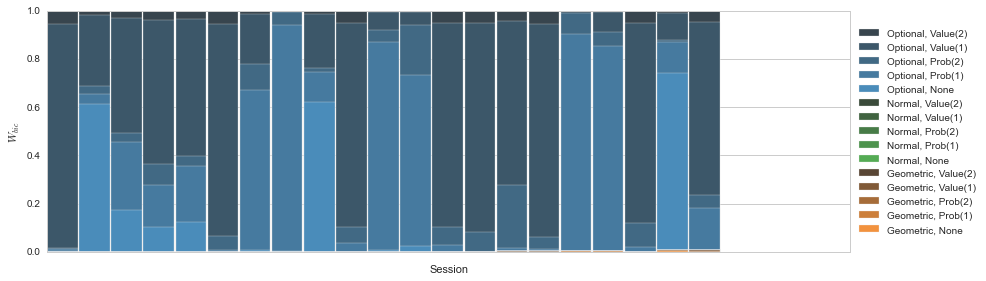

In [39]:
fig, ax = plt.subplots(figsize=(12,4))

for j, sid in enumerate(srted):

    tab = model_table(sid, force=True)[['stoprule', 'weighting', 'W_bic']]
    w = tab.sort(['stoprule', 'weighting']).W_bic.values
    
    for i, w_i in enumerate(np.cumsum(w)[::-1]):
        if j==0:
            ax.bar(j, w_i, color=col[i], alpha=1, width=.95, label=labs[i])
        else:
            ax.bar(j, w_i, color=col[i], alpha=1, width=.95)

ax.legend(loc='center left', bbox_to_anchor=(1, .5))
ax.set_ylim(0, 1)
ax.set_ylabel(r'$W_{bic}$')
ax.set_xlabel('Session')
ax.set_xticklabels([])
plt.tight_layout()
plt.show()
fig.savefig(FIGDEST + 'frey_model_weights_by_session.pdf', bbox_inches='tight')

# Best-fit model

In [81]:
model_table(29)

,sim_id,stoprule,weighting,k,N,nllh,bic,p_stay,tau,theta,p_stop,mu,sc,prelec_gamma,prelec_elevation,pow_gain,w_loss,W_bic
6,"frey_individual_planned_subj=29(mu,p_stay,sc,tau|c=0.5,theta=30)",normal,none,4,84,386.513628,790.750523,4.622154e-11,8.278388e-11,30,NaN,8.260355,21.349874,NaN,NaN,NaN,NaN,0.734790
0,"frey_individual_subj=29(p_stay,tau,theta|c=0.5)",optional,none,3,84,390.332035,793.956520,3.386315e-01,5.488692e-01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.147907
3,"frey_individual_planned_geom_subj=29(p_stay,p_stop,tau|c=0.5,theta=30)",geom,none,3,84,390.859946,795.012343,1.263479e-04,7.222179e-01,30,0.049218,NaN,NaN,NaN,NaN,NaN,NaN,0.087241
7,"frey_individual_planned_subj=29(mu,p_stay,prelec_elevation,prelec_gamma,sc,tau|c=0.5,theta=30)",normal,prob,6,84,386.270399,799.125699,2.379533e-09,1.589875e-08,30,NaN,8.260355,21.349874,1.091224,1.044273,NaN,NaN,0.011156
8,"frey_individual_planned_subj=29(mu,p_stay,pow_gain,sc,tau,w_loss|c=0.5,theta=30)",normal,value,6,84,386.367126,799.319153,4.622154e-11,8.641030e-10,30,NaN,8.260355,21.349874,NaN,NaN,0.905866,11.351716,0.010128
1,"frey_individual_subj=29(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5)",optional,prob,5,84,389.751402,801.656888,8.208205e-01,2.041095e-01,2,NaN,NaN,NaN,1.246827,1.141910,NaN,NaN,0.003147
2,"frey_individual_subj=29(p_stay,pow_gain,tau,theta,w_loss|c=0.5)",optional,value,5,84,389.883984,801.922053,3.420607e-01,5.510208e-01,4,NaN,NaN,NaN,NaN,NaN,0.836498,1.196585,0.002756
5,"frey_individual_planned_geom_subj=29(p_stay,p_stop,pow_gain,tau,w_loss|c=0.5,theta=30)",geom,value,5,84,390.421498,802.997079,3.437289e-07,2.856374e-01,30,0.049180,NaN,NaN,NaN,NaN,0.906463,2.329605,0.001610
4,"frey_individual_planned_geom_subj=29(p_stay,p_stop,prelec_elevation,prelec_gamma,tau|c=0.5,theta...",geom,prob,5,84,390.662613,803.479310,9.255841e-07,7.748588e-01,30,0.049210,NaN,NaN,1.486918,0.807103,NaN,NaN,0.001265


In [385]:
sid = 'S1'
model_ind = 0
tab = model_table(sid)
stoprule, weighting = tab.iloc[model_ind][['stoprule', 'weighting']].values
p_ind = ['none', 'prob1', 'prob2', 'value1', 'value2'].index(weighting)
print stoprule
print weighting


if stoprule == 'optional':
    model_id = 'frey_individual_subj=%s' % sid
    fixed = FIXED_OPT
    fitting = {p: PARS[p] for p in PARSETS_OPT[p_ind]}
    
    # initialize the model
    m = CHASEModel(drift='cpt', startdist='laplace', problems=problems)

elif stoprule == 'geom':
    model_id = 'frey_individual_planned_geom_subj=%s' % sid
    fixed = FIXED
    fitting = {p: PARS[p] for p in PARSETS_GEOM[p_ind]}
    
    # initialize the model
    m = CHASEAlternateStoppingModel(drift='cpt',
                                    startdist='laplace',
                                    stoprule='geometric',
                                    problems=problems)

elif stoprule == 'normal':
    model_id = 'frey_individual_planned_subj=%s' % sid
    fixed = FIXED
    fitting = {p: PARS[p] for p in PARSETS_NORMAL[p_ind]}
    
    # initialize the model
    m = CHASEAlternateStoppingModel(drift='cpt',
                                    startdist='laplace',
                                    stoprule='truncatednormal',
                                    problems=problems)

pred = predict_from_result(m, problems, model_id, fixed=fixed, fitting=fitting, outdir=OUTDIR, max_T=200)

normal
value1


In [386]:
observed_samplesize = data[(data.subject==sid)].samplesize.values - 1
predicted_samplesize = []

observed = []
predicted = []

for gid in frey2014.gamble_lab_srt:
    obs = data[(data.subject==sid) & (data.problem==gid)]
    if obs.shape[0] > 0:
        choice, ss = obs[['choice', 'samplesize']].values[0]
        observed.append(choice)
        
        if stoprule == 'optional':
            predicted.append(pred[gid]['p_resp'][1])
            predicted_samplesize.append(pred[gid]['p_stop_cond'][:,0]*pred[gid]['p_resp'][0] + pred[gid]['p_stop_cond'][:,1]*pred[gid]['p_resp'][1])
        else:
            predicted.append(pred[gid]['p_resp_t'][ss - 1][1])
            predicted_samplesize.append(pred[gid]['p_stop'])
    else:
        observed.append(np.nan)
        predicted.append(np.nan)

observed_by_type = [np.nanmean(observed[:21]),
                    np.nanmean(observed[21:42]),
                    np.nanmean(observed[42:63]),
                    np.nanmean(observed[63:])]

predicted_by_type = [np.nanmean(predicted[:21]),
                     np.nanmean(predicted[21:42]),
                     np.nanmean(predicted[42:63]),
                     np.nanmean(predicted[63:])]

choseL = np.arange(len(observed))[np.array(observed)==0]
choseH = np.arange(len(observed))[np.array(observed)==1]

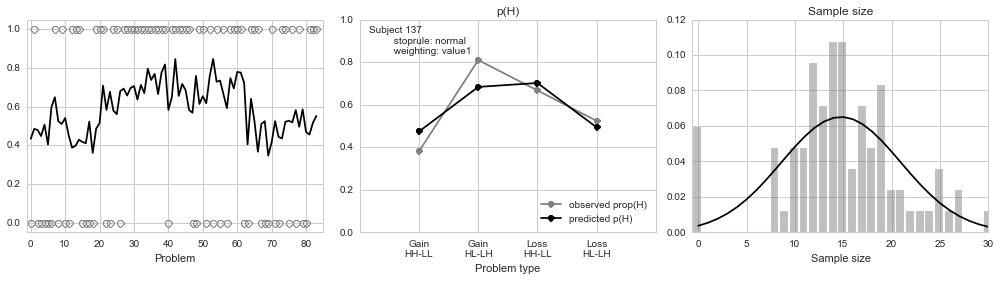

In [387]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

axi = ax[0]
axi.plot(choseH, np.ones(len(choseH)), 'o', color='gray', 
        markerfacecolor='none', markeredgecolor='gray', markeredgewidth=1)
axi.plot(choseL, np.zeros(len(choseL)), 'o', color='gray', 
        markerfacecolor='none', markeredgecolor='gray', markeredgewidth=1)
axi.plot(predicted, color='black')
axi.set_ylim(-.05,1.05)
axi.set_xlim(-1, 85)
axi.set_xlabel('Problem')

axi = ax[1]
axi.plot(observed_by_type, '-o', color='gray', label='observed prop(H)')
axi.plot(predicted_by_type, '-o', color='black', label='predicted p(H)')
axi.set_ylim(0, 1)
axi.set_xlim(-1, 4)
axi.set_xticks(range(4))
axi.set_xlabel('Problem type')
axi.set_xticklabels(['Gain\nHH-LL', 'Gain\nHL-LH', 'Loss\nHH-LL', 'Loss\nHL-LH'])
axi.set_title('p(H)')
axi.legend(loc='lower right')

axi = ax[2]
bc = np.bincount(observed_samplesize)
bc = bc / float(bc.sum())
axi.bar(np.arange(bc.size) - .5, bc, color='gray', alpha=.5)
axi.plot(np.array(predicted_samplesize).mean(axis=0),
         color='black')
axi.set_title('Sample size')
axi.set_xlim(-.6, observed_samplesize.max())
axi.set_xlabel('Sample size')

txt = '''Subject %s
         stoprule: %s
         weighting: %s''' % (sid, stoprule, weighting)
fig.text(.37, .8, txt)

plt.tight_layout()
plt.show()
fig.savefig(OUTDIR+'/bestmodel_subj=%s.pdf' % sid, bbox_inches='tight')

# Overall comparison

In [4]:
compdf = pd.DataFrame([], columns=['sid', 'sim_id', 'stoprule', 'weighting', 
                                      'k', 'N', 'nllh', 'bic', 'p_stay', 'tau', 
                                      'theta', 'p_stop', 'mu', 'sc', 
                                      'prelec_gamma', 'prelec_elevation',
                                      'pow_gain', 'w_loss'])
for sid in data.session.unique():
    tab = model_table(sid, force=True)
    #tab = tab[tab.weighting!='none']
    compdf.loc[compdf.shape[0]] = tab.iloc[0]
    compdf.loc[compdf.shape[0]-1,'sid'] = sid

In [5]:
compdf

,sid,sim_id,stoprule,weighting,k,N,nllh,bic,p_stay,tau,theta,p_stop,mu,sc,prelec_gamma,prelec_elevation,pow_gain,w_loss
0,S1,"frey_individual_session=S1(p_stay,pow_gain,tau,theta|c=0.5)",optional,value1,4,280,1371.742141,2766.023440,1.439091e-07,0.443099,6,NaN,NaN,NaN,NaN,NaN,0.789940,NaN
1,S2,"frey_individual_session=S2(p_stay,tau,theta|c=0.5)",optional,none,3,279,1364.943631,2746.780898,4.697104e-01,0.115055,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S3,"frey_individual_session=S3(p_stay,pow_gain,tau,theta|c=0.5)",optional,value1,4,280,1356.288061,2735.115280,4.764776e-01,0.230776,4,NaN,NaN,NaN,NaN,NaN,0.736410,NaN
3,S4,"frey_individual_session=S4(p_stay,pow_gain,tau,theta|c=0.5)",optional,value1,4,280,1383.417278,2789.373715,5.077936e-01,0.247979,4,NaN,NaN,NaN,NaN,NaN,0.756880,NaN
4,S5,"frey_individual_session=S5(p_stay,pow_gain,tau,theta|c=0.5)",optional,value1,4,280,1367.212108,2756.963374,2.017922e-01,0.454743,5,NaN,NaN,NaN,NaN,NaN,0.773393,NaN
5,S6,"frey_individual_session=S6(p_stay,pow_gain,tau,theta|c=0.5)",optional,value1,4,280,1347.530809,2717.600777,4.629819e-01,0.353026,4,NaN,NaN,NaN,NaN,NaN,0.580427,NaN
6,S7,"frey_individual_session=S7(p_stay,prelec_gamma,tau,theta|c=0.5)",optional,prob1,4,280,1381.543693,2785.626544,7.175570e-01,0.146899,3,NaN,NaN,NaN,1.461512,NaN,NaN,NaN
7,S8,"frey_individual_session=S8(p_stay,prelec_gamma,tau,theta|c=0.5)",optional,prob1,4,278,1328.995632,2680.501749,1.701040e-01,0.273785,5,NaN,NaN,NaN,1.252932,NaN,NaN,NaN
8,S9,"frey_individual_session=S9(p_stay,tau,theta|c=0.5)",optional,none,3,280,1348.174705,2713.253780,1.210482e-01,0.422724,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,S10,"frey_individual_session=S10(p_stay,pow_gain,tau,theta|c=0.5)",optional,value1,4,279,1372.080491,2766.685830,4.874691e-01,0.204072,4,NaN,NaN,NaN,NaN,NaN,0.505137,NaN


In [103]:
18/70.

0.2571428571428571

In [6]:
compdf['stoprule'].value_counts()

optional    21
dtype: int64

In [7]:
compdf['weighting'].value_counts()

value1    12
prob1      6
none       3
dtype: int64

In [12]:
for stoprule in ['optional']:
    for weighting in ['none', 'prob1', 'prob2', 'value1', 'value2']:
        sel = compdf[(compdf.stoprule==stoprule) & (compdf.weighting==weighting)]
        print stoprule, weighting
        print sel[['p_stay', 'tau', 'theta', 'p_stop', 'mu', 'sc', 
                   'prelec_gamma', 'prelec_elevation', 'pow_gain']].describe(percentiles=[]).loc[['count', 'mean', 'std']]

optional none
         p_stay       tau     theta  p_stop  mu  sc  prelec_gamma  \
count  3.000000  3.000000  3.000000       0   0   0             0   
mean   0.484128  0.228857  3.666667     NaN NaN NaN           NaN   
std    0.370499  0.168739  1.527525     NaN NaN NaN           NaN   

       prelec_elevation  pow_gain  
count                 0         0  
mean                NaN       NaN  
std                 NaN       NaN  
optional prob1
         p_stay       tau     theta  p_stop  mu  sc  prelec_gamma  \
count  6.000000  6.000000  6.000000       0   0   0      6.000000   
mean   0.567534  0.267960  3.500000     NaN NaN NaN      1.448671   
std    0.247611  0.144759  1.048809     NaN NaN NaN      0.106558   

       prelec_elevation  pow_gain  
count                 0         0  
mean                NaN       NaN  
std                 NaN       NaN  
optional prob2
       p_stay  tau  theta  p_stop  mu  sc  prelec_gamma  prelec_elevation  \
count       0    0      0       0   0

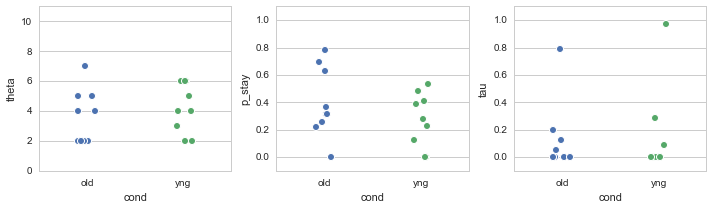

In [106]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))
sns.stripplot(x='cond', y='theta', data=compdf[compdf.stoprule=='optional'], jitter=True, ax=ax[0])
sns.stripplot(x='cond', y='p_stay', data=compdf[compdf.stoprule=='optional'], jitter=True, ax=ax[1])
sns.stripplot(x='cond', y='tau', data=compdf[compdf.stoprule=='optional'], jitter=True, ax=ax[2])
ax[0].set_ylim(0, 11)
ax[1].set_ylim(-.1, 1.1)
ax[2].set_ylim(-.1, 1.1)
plt.tight_layout()
plt.show()

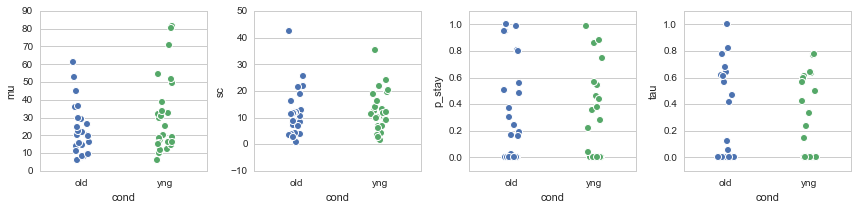

In [107]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))
sns.stripplot(x='cond', y='mu', data=compdf[compdf.stoprule=='normal'], jitter=True, ax=ax[0])
sns.stripplot(x='cond', y='sc', data=compdf[compdf.stoprule=='normal'], jitter=True, ax=ax[1])
sns.stripplot(x='cond', y='p_stay', data=compdf[compdf.stoprule=='normal'], jitter=True, ax=ax[2])
sns.stripplot(x='cond', y='tau', data=compdf[compdf.stoprule=='normal'], jitter=True, ax=ax[3])
ax[2].set_ylim(-.1, 1.1)
ax[3].set_ylim(-.1, 1.1)
plt.tight_layout()
plt.show()

In [108]:
from chase.cpt import value_fnc

def prelec(p, prelec_elevation, prelec_gamma):
    return np.exp(-prelec_elevation * ((-np.log(p)) ** prelec_gamma))

5.03373178724 nan
0.24570378126 nan
0.607023147219 nan
0.352070304334 nan
0.505606004496 nan
0.647573720354 nan
0.469411883189 nan
3.1345511091e-05 nan
0.432810496131 nan
0.198229062616 nan
0.437221811747 nan
0.306337972961 nan
0.430036239607 nan
0.643334722397 nan
0.748739805765 nan
0.705216512405 nan
0.255000386717 nan
0.39320019236 nan
0.60681604764 nan
0.358224059438 nan
0.652445784257 nan
0.463216862173 nan
0.495024084565 nan
0.546410601327 nan


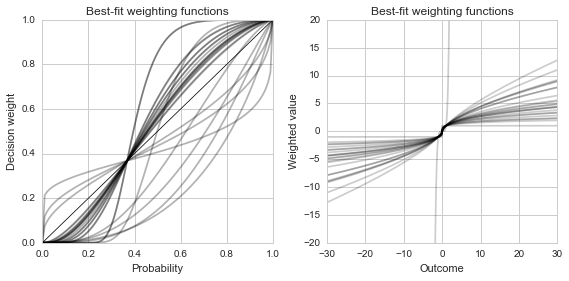

In [201]:
#col = {'old': 'red', 'yng': 'blue'}
col = {'old': 'black', 'yng': 'black'}

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

p = np.arange(0, 1.01, .01)
axi = ax[0]
axi.plot([0, 1], [0, 1], color='black', alpha=1, linewidth=.75)

for i, row in compdf[compdf.weighting=='prob2'].iterrows():
    gamma, delta = row[['prelec_gamma', 'prelec_elevation']].values
    axi.plot(p, prelec(p, delta, gamma), color=col[row.cond], alpha=.3)

for i, row in compdf[compdf.weighting=='prob1'].iterrows():
    gamma, delta = row[['prelec_gamma', 'prelec_elevation']].values
    axi.plot(p, prelec(p, 1., gamma), color=col[row.cond], alpha=.3)


axi.set_title('Best-fit weighting functions')
axi.set_xlabel('Probability')
axi.set_ylabel('Decision weight')


axi = ax[1]
axi.plot([0, 1], [0, 1], color='gray', alpha=.3)

x = np.arange(-30, 30, .1)
for i, row in compdf[compdf.weighting=='value2'].iterrows():
    alpha, lamb = row[['pow_gain', 'w_loss']].values
    #print alpha, lamb
    axi.plot(x, value_fnc(x, {'pow_gain': alpha, 'w_loss': lamb}), color=col[row.cond], alpha=.2)

for i, row in compdf[compdf.weighting=='value1'].iterrows():
    alpha, lamb = row[['pow_gain', 'w_loss']].values
    print alpha, lamb
    axi.plot(x, value_fnc(x, {'pow_gain': alpha, 'w_loss': 1.}), color=col[row.cond], alpha=.2)

axi.set_ylim(-20, 20)
axi.set_title('Best-fit weighting functions')
axi.set_xlabel('Outcome')
axi.set_ylabel('Weighted value')


plt.tight_layout()
plt.show()
fig.savefig(FIGDEST+'frey_weighting_functions.pdf', bbox_inches='tight')

In [120]:
sset_opt = np.array(compdf[compdf.stoprule=='optional'].sid.values, int)
sset_norm = np.array(compdf[compdf.stoprule=='normal'].sid.values, int)

In [86]:
observed_by_type = {}
ss_by_type = {}
choiceprop = {}
for sid in data.subject.unique():
    observed = []
    samplesize = []
    for gid in frey2014.gamble_lab_srt:
        obs = data[(data.subject==sid) & (data.problem==gid)]
        if obs.shape[0] > 0:
            choice, ss = obs[['choice', 'samplesize']].values[0]
            observed.append(choice)
            samplesize.append(ss)
        else:
            observed.append(np.nan)
            samplesize.append(np.nan)

    choiceprop[sid] = np.nanmean(observed)
    
    observed_by_type[sid] = [np.nanmean(observed[:21]),
                             np.nanmean(observed[21:42]),
                             np.nanmean(observed[42:63]),
                             np.nanmean(observed[63:])]
    ss_by_type[sid] = [np.nanmean(samplesize[:21]),
                       np.nanmean(samplesize[21:42]),
                       np.nanmean(samplesize[42:63]),
                       np.nanmean(samplesize[63:])]

In [27]:
np.array([observed_by_type[sid] for sid in sset_opt]).mean(axis=0)

array([ 0.46307435,  0.68508772,  0.58586745,  0.50406572])

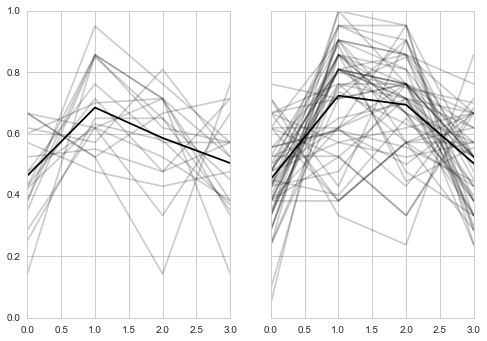

In [29]:
fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].plot(np.array([observed_by_type[sid] for sid in sset_opt]).transpose(), color='black', alpha=.2)
ax[0].plot(np.array([observed_by_type[sid] for sid in sset_opt]).mean(axis=0), color='black')
ax[1].plot(np.array([observed_by_type[sid] for sid in sset_norm]).transpose(), color='black', alpha=.2)
ax[1].plot(np.array([observed_by_type[sid] for sid in sset_norm]).mean(axis=0), color='black')
for axi in ax:
    axi.set_ylim(0, 1)
plt.show()

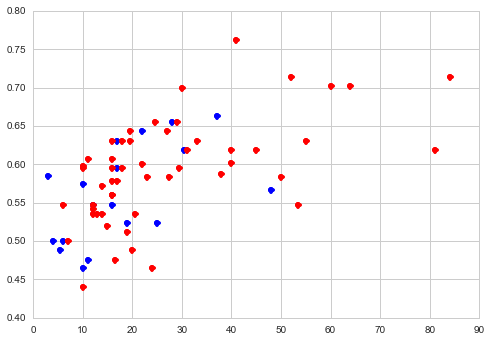

In [148]:
arr_opt = np.array([[np.mean(data[data.subject==sid].choice), np.median(data[data.subject==sid].samplesize)] \
                     for sid in sset_opt])

arr_norm = np.array([[np.mean(data[data.subject==sid].choice), np.median(data[data.subject==sid].samplesize)] \
                     for sid in sset_norm])


plt.plot(arr_opt[:,1], arr_opt[:,0], 'o', color='blue')
plt.plot(arr_norm[:,1], arr_norm[:,0], 'o', color='red')

In [185]:
arr = []
for x in arr_opt:
    arr.append(['optional', x[0], x[1]])
    
for x in arr_norm:
    arr.append(['normal', x[0], x[1]])
    
df = pd.DataFrame(arr, columns=['stoprule', 'acc', 'samplesize'])
df['eff'] = df['acc']/df['samplesize']

In [186]:
import seaborn as sns

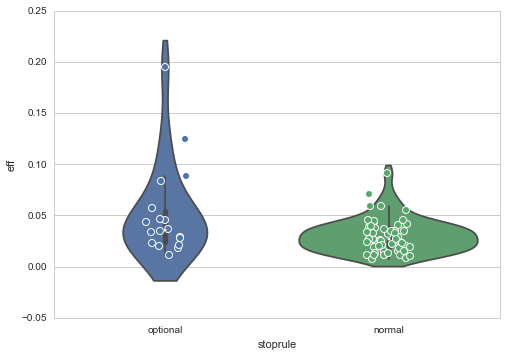

In [187]:
sns.violinplot(x='stoprule', y='eff', data=df, cut=True, alpha=.1)
sns.stripplot(x='stoprule', y='eff', data=df, jitter=True)